# Overview
In this notebook you will again perform a regression as you did in the previous exercise. This time you will

- Use more numerical variables (features)
- Predict diabetes severity
- Record your results in a hyper-parameter table

Diabetes severity is a particularly difficult clinical variable to predict. 
But even if your prediction has low accuracy, it may reveal inteeresting relationships between your features and the target variable.

Also, in the spreadsheet data science lesson (Lesson 2) you manually recorded your parameters in a table. In Lesson 3 you had to remember or write down your hyperparameters. This time you'll use Python to programatically store each experiment's hyperparameters in a Python dictionary (`dict`) and then append that dictionary to a list. That way you can display all the hyperparameters you tried (and the accuracies you achieved) in one large hyperparameter `DataFrame` (table).

## Hyperparameter table:

In the first cell below, you will set up an empty _hyperparameter_ table where you can store your model performance (like accuracy). 
A hyperparameter table is also where you store all the _hyperparameters_ you used to achieve that performance. 
That way you know what to do to recreate those same results. 

Reproducability is one of the key pieces of scientific evidence we use to decide whether a particular treatment or model represents a real phenomenon in the world.
If your experiment or model is not reproducible, that means you could have just gotten lucky. 

Hyperparameters are all the numbers and descriptions that someone else would need to reproduce your results.

### Example hyperparameters:
- Name & configuration for any scaler you used, e.g.: `'MinMaxScaler'`
- Model type or class name, e.g.: `'LinearRegression'`
- The name(s) of the features you included or ignored, e.g.: `'AGE,SEX,BP,BMI'`
- The name(s) of the target variable, e.g. `'SEVERITY'`

### Example performance scores:

- Training set accuracy or error, e.g RMSE: `rmse_train=0.33`
- Test set accuracy or error, e.g. RMSE: `rmse_test=0.42` 

In [ ]:
# results = []  # use this to delete your previous results, if you like
try:
    display(pd.DataFrame(results).round(3))
except:
    results = []

model   loss  alpha learning_rate  epsilon penalty  tol  rmse_test  \
0  SGDRegressor  huber   0.00    invscaling      0.1      l2  NaN        NaN   
1  SGDRegressor  huber   0.00    invscaling      0.1      l2  NaN        NaN   
2  SGDRegressor  huber   0.01       optimal      0.1      l2  0.0     80.707   
3           NaN    NaN    NaN           NaN      NaN     NaN  NaN     91.129   

   rmse_train  test_size  seed squared_features  
0         NaN        NaN   NaN              NaN  
1         NaN        NaN   NaN              NaN  
2      81.325        NaN   NaN              NaN  
3      90.615        0.2   0.0             True

Setting a random seed ensures that any random value generator will run the same way for anyone else that sets that same random seed.

In [ ]:
import pandas as pd
import numpy as np

hyperparams = dict(test_size=.2, seed=0)
display(pd.Series(hyperparams))

np.random.seed(hyperparams['seed'])
display(np.random.rand(2))

test_size    0.2
seed         0.0
dtype: float64

array([0.5488135 , 0.71518937])

In [ ]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

sns.set()  # seaborn settings that make prettier plots
pd.options.display.max_columns = 500
pd.options.display.max_rows = 40
pd.options.display.max_colwidth = 100
pd.options.display.min_rows = 10

In [ ]:
DATA_DIR = ""
DATA_URL = "https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt"
df = pd.read_csv(DATA_URL, sep='\t')
df.head()

AGE  SEX   BMI     BP   S1     S2    S3   S4      S5  S6    Y
0   59    2  32.1  101.0  157   93.2  38.0  4.0  4.8598  87  151
1   48    1  21.6   87.0  183  103.2  70.0  3.0  3.8918  69   75
2   72    2  30.5   93.0  156   93.6  41.0  4.0  4.6728  85  141
3   24    1  25.3   84.0  198  131.4  40.0  5.0  4.8903  89  206
4   50    1  23.0  101.0  192  125.4  52.0  4.0  4.2905  80  135

The `diabetes.tab.txt` file is a tab-delimitted text file with the original unnormalized units (age in years, blood pressure in mmHg, gender as 1 for female, 2 for male.
The `diabetes.rwrite1.txt` url will load a dataset with standardized values for each feature, but more informative column names. In both data sets, here is what the names mean.
0. age: in years  
1. sex: 1=male, 2=female  
2. bmi: body mass index >35=obese, >30=overweight, <18.5=underweight  
3. bp/map: mean arterial pressure (blood pressure, systolic+diastolic divided by 2)  
4. s1/tc: TC level is a measure of a B12 transportation molecule that is not bound to B12 yet. I high ratio of holotranscobalamin (holo TC or TCH) to transcobalamin (TC) indicates healthy availability of B12 for absorption. TCH above 50 pmol/liter is considered good.  
5. s2/ldl: Low density lipid (good cholesterol)   
6. s3/hdl: High density Lipid cholesterol (bad cholesterol)  
7. s4/tch: holo TC level? (B12 bound tot he transport molecule, **t**rans**c**obalamin, to create **h**olo**t**rans**c**obalamin), <35pmol/L=B12deficiency, >50pmol/L=goodB12  
8. s5/ltg:  
9. s6/glu: glucose level  
10. y: a quantitative measure of disease progression one year after baseline  

In [ ]:
df_rewrite = pd.read_csv('https://www4.stat.ncsu.edu/~boos/var.select/diabetes.rwrite1.txt', sep=' ')
column_names = list(df_rewrite.columns)
df.columns = column_names
df.head().round(1)

age  sex   bmi    map   tc    ldl   hdl  tch  ltg  glu    y
0   59    2  32.1  101.0  157   93.2  38.0  4.0  4.9   87  151
1   48    1  21.6   87.0  183  103.2  70.0  3.0  3.9   69   75
2   72    2  30.5   93.0  156   93.6  41.0  4.0  4.7   85  141
3   24    1  25.3   84.0  198  131.4  40.0  5.0  4.9   89  206
4   50    1  23.0  101.0  192  125.4  52.0  4.0  4.3   80  135

Below you can see how to rename the tc column to `"bp"` for blood pressure.
You can rename the `"y"` column to `"severity"` to be explicit about what it means (diabetes severity score one year after the initial hospital visit).

In [ ]:
column_names[3] = 'bp'
column_names[-1] = 'severity'
df.columns = column_names
display(df.round(1))

age  sex   bmi     bp   tc    ldl   hdl  tch  ltg  glu  severity
0     59    2  32.1  101.0  157   93.2  38.0  4.0  4.9   87       151
1     48    1  21.6   87.0  183  103.2  70.0  3.0  3.9   69        75
2     72    2  30.5   93.0  156   93.6  41.0  4.0  4.7   85       141
3     24    1  25.3   84.0  198  131.4  40.0  5.0  4.9   89       206
4     50    1  23.0  101.0  192  125.4  52.0  4.0  4.3   80       135
..   ...  ...   ...    ...  ...    ...   ...  ...  ...  ...       ...
437   60    2  28.2  112.0  185  113.8  42.0  4.0  5.0   93       178
438   47    2  24.9   75.0  225  166.0  42.0  5.0  4.4  102       104
439   60    2  24.9   99.7  162  106.6  43.0  3.8  4.1   95       132
440   36    1  30.0   95.0  201  125.2  42.0  4.8  5.1   85       220
441   36    1  19.6   71.0  250  133.2  97.0  3.0  4.6   92        57

[442 rows x 11 columns]

You can select the columns you'd like to predict (the target variable) below.  
You can also see here how to create a `for` loop on a single line.  
A list comprehension is when you have a `for` loop between square brackets (`[]`).  
Square brackets are the python symbol used to define a `list`.  

In [ ]:
target_names = ['severity']
feature_names = ['age', 'sex', 'bmi']
# feature_names = [name for name in df.columns if name not in target_names]
print(f' target_names: {target_names}')
print(f'feature_names: {feature_names}')


 target_names: ['severity']
feature_names: ['age', 'sex', 'bmi']


One of the most useful visualizations for machine learning is a scatter plot or pair plot.  
It's especially useful when you plot the target variable on the vertical (y) axis and your feature variables on the horizontal axes.  

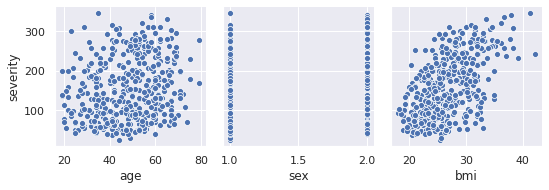

In [ ]:
fig = sns.pairplot(df, x_vars=feature_names[:4], y_vars=target_names)


In [ ]:
# fig = sns.pairplot(df, x_vars=feature_names[4:7], y_vars=target_names)

In [ ]:
# fig = sns.pairplot(df, x_vars=feature_names[7:], y_vars=target_names)

Create a training and testset.  
The training set is like the question and answer pairs you get to see during a school lesson.  
The test set is like the exam question and answer pairs that the teacher grades you on at the end of the course.  
Use the training set to show your machine learning model the relationship between your features (age, gender, bmi, blood tests etc) and your target variables (diabetes severity).  
You will use the training set to traiin or fit the model.  
You'll use the test set to see how well you model will work (it's accuracy, standard error, precision, recall, etc) in the real world.  
You'll make predictions for the test set "questions" (`X_test`) and see how closely they match the test set answers (`y_test`).

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[feature_names], df[target_names], test_size=hyperparams['test_size'])
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)
y_train = pd.DataFrame(y_train, columns=target_names)
y_test = pd.DataFrame(y_test, columns=target_names)
print(f'X_train.shape: {X_train.shape}; y_train.shape: {y_train.shape}')
print(f' X_test.shape: {X_test.shape};  y_test.shape: {y_test.shape}')


X_train.shape: (353, 3); y_train.shape: (353, 1)
 X_test.shape: (89, 3);  y_test.shape: (89, 1)


The `DataFrame` method called `.describe()` is great for getting summary statistics about your training set.  
You can see here that our training set has 353 examples.  
Additional statistics for the range and mean (average) are also provided.  

In [ ]:
display(X_train.describe(include='all'))

age         sex         bmi
count  353.000000  353.000000  353.000000
mean    48.433428    1.470255   26.385269
std     12.918086    0.499823    4.322011
min     19.000000    1.000000   18.000000
25%     38.000000    1.000000   23.300000
50%     50.000000    1.000000   25.700000
75%     58.000000    2.000000   29.000000
max     79.000000    2.000000   42.200000

Do the same for the target variable in the training set:

In [ ]:
display(y_train.describe(include='all'))

severity
count  353.000000
mean   151.288952
std     77.452634
min     25.000000
25%     87.000000
50%    139.000000
75%    210.000000
max    346.000000

In this exercise you will learn how to tune an `SGDRegressor` (Stochastic Gradient Descent Linear Regression).  
An `SGDRegressor` is much faster for large datasets.  
It also has many more hyperparameters (settings) you can use to improve it's accuracy on difficult problems.  

In [ ]:
from sklearn.linear_model import SGDRegressor
model = SGDRegressor(loss='huber')
model = SGDRegressor(alpha=0.01, loss='huber', learning_rate='optimal', tol=.0001)
model

SGDRegressor(alpha=0.01, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='optimal', loss='huber', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [ ]:
model_params = dict(model=model.__class__.__name__,
                    loss=model.loss,
                    alpha=model.alpha,
                    learning_rate=model.learning_rate,
                    epsilon=model.epsilon,
                    penalty=model.penalty,
                    tol=model.tol,
                    )
results.append(model_params)
display(results[-1])

{'alpha': 0.01,
 'epsilon': 0.1,
 'learning_rate': 'optimal',
 'loss': 'huber',
 'model': 'SGDRegressor',
 'penalty': 'l2',
 'tol': 0.0001}

You can use the default hyperparameters within `SGDRegressor` for your first attempt to fit this dataset.

In [ ]:
model.fit(X_train, y_train.values[:,0])

SGDRegressor(alpha=0.01, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='optimal', loss='huber', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

The `n_iter_` attribute of your model contains a count of the number of "attempts" the `SGDRegressor` took to try to fit your data. 
Since you set the random seed to the same value that I did, you should see that it took 111 passes through the data (attempts) to get the fit right. 

In [ ]:
model.n_iter_

14

The `coef_` attribute of your model contains an array, or list, of all the coefficients that it found to fit your data the best. 
Since SGDRegressor is basically just a "trial-and-error" LinearRegression, these are the same as the slopes you would get if you trained a LinearRegression on this same data.

In [ ]:
pd.Series(model.coef_, index=feature_names)

age   -0.070751
sex   -0.329621
bmi    5.856933
dtype: float64

From the coefficients above you can see that each year of age reduces your diabetes severity in subsequent years by about 0.2 points (out of 300 total points for maximum severity diabetes). 
Perhaps the older people get the more likely they are to manage their diet. 
Or perhaps we're seeing some survivorship bias. 
Those that live to an older age tend to not have worsening diabetes. 
Remember that this diabetes severity score is for the year after the first visit to the doctor.

In [ ]:
model.score(X_train, y_train)

0.2726558754845818

In [ ]:
model.score(X_test, y_test)

0.293958914458483

From the correlation coefficient on the training set (27%) and the test set (15%), you can see that our SGD Regressor is overfitting.
It's doing better on our training set thatn the test set. 
This is like a student that does better on the quizzes because you tell them the answers to the quizzes, but doesn't do so well on the tests, because you don't reveal the answers to the tests during the school year (training).


You can compute predictions on the training and test set and compare them to the truth to see how well your model did.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


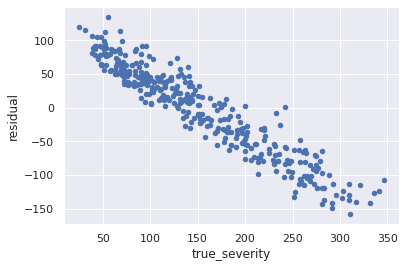

In [ ]:
y_train_pred = model.predict(X_train)
df_y_train = pd.DataFrame(y_train_pred, columns=['pred_severity'])
df_y_train['true_severity'] = y_train.values.flatten()
df_y_train['residual'] = y_train_pred - y_train.values.flatten()
df_y_train
df_y_train.plot(kind='scatter', x='true_severity', y='residual')

In [ ]:

y_test_pred = model.predict(X_test[feature_names])
y_train_pred = model.predict(X_train[feature_names])
rmse_test = np.sqrt(np.mean((y_test_pred - y_test.values) ** 2))
rmse_train = np.sqrt(np.mean((y_train_pred - y_train.values) ** 2))
results[-1]['rmse_test'] = rmse_test
results[-1]['rmse_train'] = rmse_train
display(pd.DataFrame(results).round(2))


model   loss  alpha learning_rate  epsilon penalty  tol  rmse_test  \
0  SGDRegressor  huber   0.00    invscaling      0.1      l2  NaN        NaN   
1  SGDRegressor  huber   0.00    invscaling      0.1      l2  NaN        NaN   
2  SGDRegressor  huber   0.01       optimal      0.1      l2  0.0      80.71   

   rmse_train  
0         NaN  
1         NaN  
2       81.32

In [ ]:
rmse_overfit_ratio = round((rmse_test - rmse_train) / rmse_test, 5)
rmse_overfit_ratio

-0.00765

In [ ]:
hyperparams['squared_features'] = True

In [ ]:
X_train = X_train ** 2
X_test = X_test ** 2

In [ ]:
model.fit(X_train, y_train)
results.append(hyperparams)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:

y_test_pred = model.predict(X_test[feature_names])
y_train_pred = model.predict(X_train[feature_names])
rmse_test = np.sqrt(np.mean((y_test_pred - y_test.values) ** 2))
rmse_train = np.sqrt(np.mean((y_train_pred - y_train.values) ** 2))
results[-1]['rmse_test'] = rmse_test
results[-1]['rmse_train'] = rmse_train
display(pd.DataFrame(results).round(2))


model   loss  alpha learning_rate  epsilon penalty  tol  rmse_test  \
0  SGDRegressor  huber   0.00    invscaling      0.1      l2  NaN        NaN   
1  SGDRegressor  huber   0.00    invscaling      0.1      l2  NaN        NaN   
2  SGDRegressor  huber   0.01       optimal      0.1      l2  0.0      80.71   
3           NaN    NaN    NaN           NaN      NaN     NaN  NaN      91.13   

   rmse_train  test_size  seed squared_features  
0         NaN        NaN   NaN              NaN  
1         NaN        NaN   NaN              NaN  
2       81.32        NaN   NaN              NaN  
3       90.61        0.2   0.0             True

NameError: ignored